In [1]:
import sys
import os
import numpy as np
import pickle
import pandas as pd
import seaborn as sns
import sklearn
import matplotlib.pyplot as plt
import itertools
import qinfer as qi
from lfig import LatexFigure
import copy

sys.path.append("/home/bf16951/QMD")
import qmla

%matplotlib inline

In [2]:
runs_and_instances = {
    "19_39" : [1,2,7,4],
    "19_40" :[1,2,3,8],
    "19_42" : [1,2,3,4], 
    "19_47" : [1,2,3,4]
}

In [5]:
experiments = sorted(range(1001))


heuristic_names = {
    'MultiParticleGuessHeuristic' : "PGH", 
    'TimeList' : r"$t$ list", 
    'FixedNineEighthsToPowerK' : r"$\left( \frac{9}{8}\right)^k$", 
    'RandomTimeUpperBounded' : r"Random$(0, t_{max})$"    
}
name_descriptions = {
    "pauliSet_1_z_d1" : r'$\hat{H}_1$',
    "pauliSet_1_x_d1+pauliSet_1_y_d1+pauliSet_1_z_d1" :  r'$\hat{H}_2$', 
    "pauliSet_1J3_zJz_d5+pauliSet_1J4_zJz_d5+pauliSet_1J5_zJz_d5+pauliSet_2J4_zJz_d5+pauliSet_2J5_zJz_d5+pauliSet_3J4_zJz_d5+pauliSet_3J5_zJz_d5" : r'$\hat{H}_3$',  
    "pauliSet_1J2_zJz_d4+pauliSet_1J3_zJz_d4+pauliSet_2J3_xJx_d4+pauliSet_2J3_zJz_d4+pauliSet_2J4_xJx_d4+pauliSet_3J4_zJz_d4" : r'$\hat{H}_4$', 
}

In [6]:
volumes = pd.DataFrame()

for run_dir in runs_and_instances:
    run_path = "Nov_27/{}".format(run_dir)
    
    for instance in runs_and_instances[run_dir]:
    
        results = qmla.load_results(
            results_folder = "/home/bf16951/thesis/qmla_run_data",
            results_time = run_path,
            instance_id = instance
        )
        q = results['qmla_instance']
        model = q.get_model_storage_instance_by_id(1)
        
        times = copy.copy(model.times_learned_over)
        times.insert(0, None)
        times[1].item()
        this_models_volumes = pd.DataFrame(
            np.array([
                [
                    heuristic_names[model.model_heuristic_class], 
                    q.exploration_class.latex_name(model.name), 
                    model.name,  
                    name_descriptions[model.name], 
                    e, 
                    float(model.volume_by_epoch[e]),
                    times[e].item() if times[e] is not None else None,
                ] for e in experiments
            ]),
            columns = ['heuristic', 'model', 'raw_name', "description",  'experiment', 'volume', 'time']
        )
    
        
        volumes = volumes.append(this_models_volumes, ignore_index=True)
volumes.experiment = volumes.experiment.astype(float)
volumes.volume = volumes.volume.astype(float)
sorted_probes = ['$|0\\rangle$', '$|+\\rangle$', '$|t\\rangle$', '$| r \\rangle$']
sorted_heuristics = [
    heuristic_names["RandomTimeUpperBounded"], 
    heuristic_names["TimeList"],
    heuristic_names["FixedNineEighthsToPowerK"], 
    heuristic_names["MultiParticleGuessHeuristic"]
]
experiments = list(range(1001))

/usr/local/lib/python3.5/dist-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "
/usr/local/lib/python3.5/dist-packages/matplotlib/figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "
/usr/local/lib/python3.5/dist-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


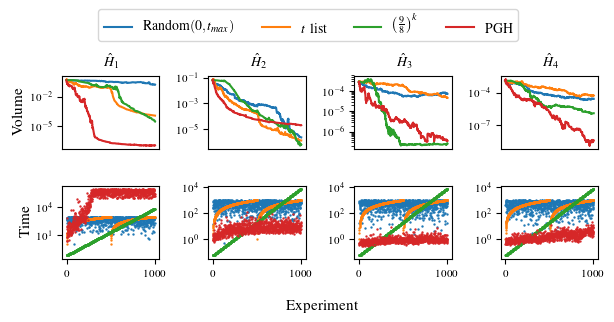

In [7]:
lf = LatexFigure(
    fraction=1, 
    gridspec_params = {'wspace' : 0.5, 'hspace' : 0.5},
    gridspec_layout=(2,4)
)

descriptions = volumes.description.unique()

sorted_heuristics = [
    heuristic_names["RandomTimeUpperBounded"], 
    heuristic_names["TimeList"],
    heuristic_names["FixedNineEighthsToPowerK"], 
    heuristic_names["MultiParticleGuessHeuristic"]
]


for col in range(len(descriptions)):
    
#     col = descriptions.index(desc)
    desc = descriptions[col]
    model_name = volumes[volumes.description == desc].model.unique()[0]
    data = volumes[volumes.description == desc]

    for heuristic in sorted_heuristics:
        # volumes
        ax = lf.new_axis(
            force_position = (0, col),
            auto_label=False
        )

        these_volumes = data[
            data.heuristic == heuristic
        ].volume.values
  
        ax.plot(
            experiments, 
            these_volumes,
            label = heuristic
        )
        ax.semilogy()
        ax.set_xticks([])
    
#         # times
        ax = lf.new_axis(
            force_position = (1, col),
            auto_label = False
        )
        these_times = data[
            data.heuristic == heuristic
        ].time.values
  
        ax.scatter(
            experiments, 
            these_times,
#             lw = 0.2, 
            s = 0.5, 
        )
        ax.set_ylabel("")
        ax.semilogy()
    
lf.gridspec_axes[(0,1)].legend(
    ncol=4,
    bbox_to_anchor=(3.25, 2)
)

lf.gridspec_axes[(0,0)].set_ylabel("Volume")
lf.gridspec_axes[(1,0)].set_ylabel("Time")

for c in range(4):
    lf.gridspec_axes[(0,c)].set_title(descriptions[c])



lf.fig.text(0.5, -0.1, "Experiment", ha='center')

lf.save("/home/bf16951/thesis/qmla_run_data/Nov_27/heuristic_comparisons.pdf")
